# 1. About this project

National Institutes of Health Chest X-Ray Dataset
https://www.kaggle.com/nih-chest-xrays/data

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. The dataset contains X-Ray images of chest diagnosed with 13 diseases(including "no disease found"). In this project we applied convolutional neural network to predict and classify images into particular diseases. 

The reason we chose this method is that convolutional neural network is more powerful than other methods such as Clustering, K-Means, or K-Nearest Neighbour(KNN) for image recognition. Since even for doctors diagnosing patients with X-Ray images using their naked eyes is difficult, we would like to use AI to help doctors' diagnostic decision.

# For teachers: instruction for data preparation

To reload our project, it is necessary to download some data.
From https://www.kaggle.com/nih-chest-xrays/data, we kindly ask you to download files below and uncompress the zip file. These folders should be stored in the same directory as this jupyter notebook.


images_001.zip                                            
Please uncompress it and rename the folder as "images_test".                                            
We use these images for testing.                                            
(https://www.kaggle.com/nih-chest-xrays/data/downloads/images_001.zip)

images_002.zip                                            
Please uncompress it and rename the folder as "images_2".                                            
We use these images for training.                                            
(https://www.kaggle.com/nih-chest-xrays/data/downloads/images_002.zip)

Data_Entry_2017.csv                                       
(https://www.kaggle.com/nih-chest-xrays/data/downloads/Data_Entry_2017.csv)

# 2. Structure of Dataset

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images(each sized 1024x1024 pixels) with disease labels from 30,805 unique patients. This original dataset, amounting around 41GB, contains 14 categories(13 diseases and no diseases found), and many images were diagnosed with combination of several diseases. In total, there are about 780 diagnostic categories. 
As we start the project, we found out that this dataset is too heavy and complicated for our computers to work with, therefore we decided to downsize the problem with four methods.

# 3. Downsizing the problem

1.Choosing images   
    Due to the restriction of the power of our computers, we extracted 1200 images(300 images x 3 diseases, and 300 images of "no disease found") for training, and 400 images(100 images x 3 diseases, and 100 images of "no disease found") for testing. We would like to note that if we have more powerful resources such as GPU, we can make more accurate prediction using the same model that we created with fewer images.


2.Resizing images   
    The original images were 1024x1024 pixels. To reduce the amount of data, we downsized them into 256x256 pixels. Here we demonstrate one example of downsizing.

In [3]:
import PIL
from PIL import Image
import os
from matplotlib.pyplot import imshow
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import numpy as n

# This function displays image with its path
def display_image(img_path):
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img, cmap='gray')

    

baseheight = 256
img = Image.open(os.getcwd()+'/images_2/00003925_000.png')
hpercent = (baseheight / float(img.size[1]))
wsize = int((float(img.size[0]) * float(hpercent)))
img = img.resize((wsize, baseheight), PIL.Image.ANTIALIAS)
img.save(os.getcwd()+'/images_2/testpicture.png')
original  = cv2.imread(os.getcwd()+'/images_2/00003925_000.png')
reduced = cv2.imread(os.getcwd()+'/images_2/testpicture.png')


Before downsizing: the image size is 1024x1024


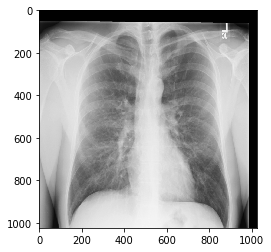

In [147]:
print("Before downsizing: the image size is 1024x1024")
display_image(os.getcwd()+"/images_2/00003925_000.png")

After downsizing: the image size is 256x256


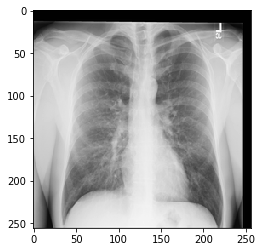

In [148]:
print("After downsizing: the image size is 256x256")
display_image(os.getcwd()+"/images_2/testpicture.png")

3.Converting images into contour lines   
    The original images were already gray scaled, however, they were still too heavy for our computers, so we converted them into contour lines.
    By downsizing images and converting images into contours, we were able to reduce the data size to 1/25 of the original. Here we demonstrate one example of conversion into contour lines.

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

 
def Change_threhole(x):
 # get current positions of four trackbars
  T1 = cv2.getTrackbarPos('T1','home_canny')
  T2 = cv2.getTrackbarPos('T2','home_canny')
  edges = cv2.Canny(img,T1,T2)
  cv2.imshow('home_canny',edges)
  cv2.imshow('home',img)

def creat_contour(filepath, savepath, resize_size):
    cv2.namedWindow('home_canny', cv2.WINDOW_NORMAL) #WINDOW_AUTOSIZE 
    cv2.namedWindow('home', cv2.WINDOW_NORMAL) #WINDOW_AUTOSIZE   
       
    cv2.createTrackbar('T1','home_canny',0,500,Change_threhole)
    cv2.createTrackbar('T2','home_canny',0,500,Change_threhole)
     
    img = cv2.imread(filepath,0)
    edges = cv2.Canny(img,25,25)   ##initial value
    resized_edges = cv2.resize(edges, (resize_size, resize_size)) 
    #cv2.imshow('home_canny',edges)
    cv2.imwrite(savepath,resized_edges)

In [151]:
filepath = os.getcwd()+'/images_2/testpicture.png'
savepath = os.getcwd()+'/images_2/testpicture_contour.png'
creat_contour(filepath, savepath, 256)

Before: the image size is 256x256


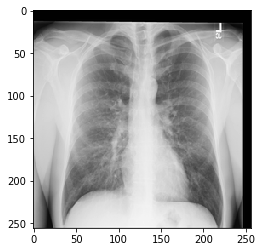

In [149]:
print("Before: the image size is 256x256")
display_image(os.getcwd()+"/images_2/testpicture.png")

After: the image size is 256x256 but converted into contour lines


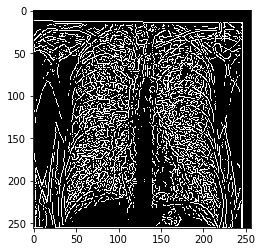

In [153]:
print("After: the image size is 256x256 but converted into contour lines")
display_image(os.getcwd()+"/images_2/testpicture_contour.png")

4.Choosing diseases to predict   
    To make the prediction simple, out of 112,120 images, we chose the most frequest 4 diseases("No disease found": 60412, Infiltration: 9551, Atelectasis: 4212, Effusion: 3959).

Below we apply downsizing methods 1~4 at once to all the images, and create folders to store them.

In [5]:
import csv 
import PIL
from PIL import Image
import os



# build a function to resize the images, convert them into contour lines, 
# create train folder and validation folder of each disease,
# and put images into proper folders.
def build_training_data_contour(baseheight, disease_id , root_folder, image_folder_name, 
               class_list, nb_train_Nofinding, nb_train_disease, 
               nb_validation_Nofinding, nb_validation_disease):
    
# Explanations for parameters
# baseheight :   Downsize into 256x256 pixels
# class_list = ["No Finding", "Infiltration", "Atelectasis","Effusion"]
# disease_id :  1 is Infiltration, 2 is Atelectasis, etc....
# disease = class_list[disease_id]
# root_folder : the directory you place the original images 
# image_folder_name = "images"
# nb_train_Nofinding : number of "no disease found" images for training
# nb_train_disease : number of images of each disease for training
#                           (By default Infiltration)
# nb_validation_Nofinding :number of "no disease found" images for validation
# nb_validation_disease : number of images of each disease for validation
#                              (By default Infiltration)
 
     
    f = open(root_folder+"/Data_Entry_2017.csv", 'r')
    reader = csv.reader(f)
    k =0
    I = 0
    
    disease = class_list[disease_id]
    
    main_data_folder = root_folder + '/data_'+disease+"_contour"
    train_folder = main_data_folder + "/train"
    train_No_finding = main_data_folder +"/train/No_finding"
    train_disease = main_data_folder +"/train/" + disease
    
    validation_folder = main_data_folder+"/validation"
    validation_No_finding = main_data_folder +"/validation/No_finding"
    validation_disease = main_data_folder + "/validation/" + disease
    
    import shutil
    try:
        shutil.rmtree(main_data_folder)
    except:
        pass
    
    os.mkdir(main_data_folder)
    os.mkdir(train_folder)
    os.mkdir(train_No_finding)
    os.mkdir(train_disease)
    os.mkdir(validation_folder)
    os.mkdir(validation_No_finding)
    os.mkdir(validation_disease)
    
    for row in reader:
        try:
            if row[1] == class_list[0] :
                filepath = root_folder+ "/"+image_folder_name + "/"  + row[0]
                if os.path.exists(filepath):
                    k+=1
                    if k in range(nb_train_Nofinding+1): 
                        savepath = train_No_finding +"/"+ row[0]
                        creat_contour(filepath, savepath, baseheight)
                    if k in range(nb_train_Nofinding+1 , nb_train_Nofinding + nb_validation_Nofinding +1): 
                        savepath = validation_No_finding +"/"+ row[0]
                        creat_contour(filepath, savepath, baseheight)
                    
            elif row[1] == class_list[disease_id] :
                filepath = root_folder+ "/"+image_folder_name + "/"  + row[0]
                if os.path.exists(filepath):
                    I+=1
                    if I in range(nb_train_disease+1): 
                        savepath = train_disease +"/"+ row[0]
                        creat_contour(filepath, savepath, baseheight)
                    if I in range(nb_train_disease +1 ,nb_validation_disease + nb_train_disease +1): 
                        savepath = validation_disease +"/"+ row[0]
                        creat_contour(filepath, savepath, baseheight)
                    
            
        except:
            pass
    f.close()
    print("Number of No_finding label in the whole image data set = ", k)
    print("Number of This disease label in the whole image data set = = ", I)

# 4. Solution

Our solution is to create three different prediction model using convolutional neural network for each disease. Each model carries out a binary prediction between a particular disease and "no disease found". With each test image, we test with the three models(it means for each test image, we test three times), and each model tells us the probability that the image is diagnosed with the disease. Hence we can make a conclusion on which disease the image is more likely to be diagnosed. 

We did not make a model which can predict images into three categories of diseases and "no disease found" at once, since it requires more layers therefore CPU power to train.

For makeing a prediction model, we used a package called Keras. Keras is a high-level neural networks API, written in Python and capable of running on top of Tensorflow. 

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# define a functino to train each model
def train_model_number(disease_id, epochs = 2, batch_size = 20):
    #disease_id=  1 if Infiltration, 2 if Atelectasis, etc....
    
    # dimensions of our images.
    baseheight= 256
    class_list = ["No Finding", "Infiltration", "Atelectasis", "Effusion"]
    
    disease = class_list[disease_id]

    root_folder= os.getcwd()   # the directory you place the original images 
    image_folder_name = "images_2"
    nb_train_Nofinding = 300  # number of "no disease found" images for training
    nb_train_disease = 300  # number of images of each disease for training(By default Infiltration)
    nb_validation_Nofinding = 50  # number of "no disease found" images for validation
    nb_validation_disease = 50  # number of images of each disease for validation(By default Infiltration)

    build_training_data_contour(baseheight, disease_id , root_folder, image_folder_name,
                   class_list, nb_train_Nofinding, nb_train_disease, 
                   nb_validation_Nofinding, nb_validation_disease )


    img_width, img_height = baseheight, baseheight


    main_data_folder = root_folder + '/data_'+disease+ "_contour"

    train_data_dir = main_data_folder + "/train"
    validation_data_dir =  main_data_folder+"/validation"
    nb_train_samples = nb_train_Nofinding + nb_train_disease   #total
    nb_validation_samples = nb_validation_Nofinding + nb_validation_disease  # total

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)
    
    model = Sequential()  # Open a training session
    model.add(Conv2D(32, (3, 3), input_shape=input_shape)) # Add a convolution layer with 
                                                           # 3x3 convolution product matrix
        
    model.add(Activation('relu'))   # activation function is a function to set a threshold 
                                    # for activating a neural network.
                                    # Relu(rectified linear units) is 
                                    # a type of activation functions.
                
    model.add(MaxPooling2D(pool_size=(2, 2))) # Use Maximum Pooling to highlight the feature
                                              # in the image

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    # Dense(64) is a fully-connected layer with 64 hidden units.
    # in the first layer, you must specify the expected input data shape:
    
    model.add(Activation('relu'))
    model.add(Dropout(0.5))  # Drop out function to prevent the over fitting
                             # fully connected layer, it is dimension 1 
                             # because it's the final output.
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=5)

    model.save(root_folder+'/model_'+disease +'_contour'+'.h5')


/Users/makotomiyazaki/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/makotomiyazaki/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [19]:
train_model_number(disease_id = 1, epochs = 2, batch_size = 20) 
# Infiltration,  
#only train for 2 round, 
#and we will continue the training with the function "continue_train_model_number(disease_id)"

k =  16873
I =  1921
Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/2
30/30 [==============================] - 121s 4s/step - loss: 0.7935 - acc: 0.5000 - val_loss: 0.6953 - val_acc: 0.3900
Epoch 2/2
30/30 [==============================] - 101s 3s/step - loss: 0.6987 - acc: 0.5417 - val_loss: 0.6959 - val_acc: 0.4600


In [38]:
train_model_number(disease_id = 2, epochs = 2, batch_size = 20) # Atelectasis

Number of No_finding label in the whole image data set =  16873
Number of This disease label in the whole image data set = =  1190
Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/2
30/30 [==============================] - 127s 4s/step - loss: 1.0939 - acc: 0.4800 - val_loss: 0.6924 - val_acc: 0.5700
Epoch 2/2
30/30 [==============================] - 97s 3s/step - loss: 0.7041 - acc: 0.5067 - val_loss: 0.6900 - val_acc: 0.5800


In [39]:
train_model_number(disease_id = 3, epochs = 2, batch_size = 20) # Effusion

Number of No_finding label in the whole image data set =  16873
Number of This disease label in the whole image data set = =  1015
Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/2
30/30 [==============================] - 107s 4s/step - loss: 0.8574 - acc: 0.5483 - val_loss: 0.6894 - val_acc: 0.5900
Epoch 2/2
30/30 [==============================] - 92s 3s/step - loss: 0.6961 - acc: 0.5900 - val_loss: 0.6804 - val_acc: 0.5700


As shown above, the accuracy starts with around 0.5, because the model is for a binary classification. As the iterations goes on, the accuracy goes up from 0.5.

# 5. Creat a module to continue training from interrupted point
The following codes allow us to reload the model we trained above and continue the training. This shows that we can overwrite previously trained models and improve the accuracy.

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import load_model


def load_disease_model_contour(disease_id):
    class_list = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "Mass"]
    disease = class_list[disease_id]
    model_name = os.getcwd()+"/model_"+disease + '_contour'+".h5"
    return model_name
    
def continue_train_model_number(disease_id, epochs = 60, batch_size = 30):   
    #disease_id=  1 if Infiltration, 2 if Atelectasis, etc....
    
    # dimensions of our images.
    baseheight= 256
    class_list = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "Mass"]
    
    disease = class_list[disease_id]

    root_folder= os.getcwd()
    image_folder_name = "images"
    nb_train_Nofinding = 300
    nb_train_disease = 300
    nb_validation_Nofinding = 50
    nb_validation_disease = 50


    img_width, img_height = baseheight, baseheight


    main_data_folder = root_folder + '/data_'+disease + "_contour"

    train_data_dir = main_data_folder + "/train"
    validation_data_dir =  main_data_folder+"/validation"
    nb_train_samples = nb_train_Nofinding + nb_train_disease   #total
    nb_validation_samples = nb_validation_Nofinding + nb_validation_disease  # total

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = load_model(load_disease_model_contour(disease_id))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=5)

    model.save(root_folder+'/model_'+disease+'_contour' +'.h5')

In [54]:
# Just to show that we can resume the previously trained model above from the interrupted point.
continue_train_model_number(disease_id = 1, epochs = 60, batch_size = 20)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/60
30/30 [==============================] - 114s 4s/step - loss: 0.7403 - acc: 0.5533 - val_loss: 1.0473 - val_acc: 0.5000
Epoch 2/60
30/30 [==============================] - 96s 3s/step - loss: 0.7028 - acc: 0.5400 - val_loss: 0.6843 - val_acc: 0.5000
Epoch 3/60
30/30 [==============================] - 103s 3s/step - loss: 0.6868 - acc: 0.5833 - val_loss: 0.6587 - val_acc: 0.6800
Epoch 4/60
30/30 [==============================] - 336s 11s/step - loss: 0.6867 - acc: 0.5833 - val_loss: 0.6572 - val_acc: 0.6800
Epoch 5/60
30/30 [==============================] - 95s 3s/step - loss: 0.6853 - acc: 0.5583 - val_loss: 0.6309 - val_acc: 0.6800
Epoch 6/60
30/30 [==============================] - 86s 3s/step - loss: 0.6711 - acc: 0.5767 - val_loss: 0.6577 - val_acc: 0.6200
Epoch 7/60
30/30 [==============================] - 778s 26s/step - loss: 0.6576 - acc: 0.6017 - val_loss: 0.6264 - val_acc: 0.6200
Ep

In [54]:
# Just to show that we can resume the previously trained model above from the interrupted point.
continue_train_model_number(disease_id = 2, epochs = 60, batch_size = 20)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/60
30/30 [==============================] - 114s 4s/step - loss: 0.7403 - acc: 0.5533 - val_loss: 1.0473 - val_acc: 0.5000
Epoch 2/60
30/30 [==============================] - 96s 3s/step - loss: 0.7028 - acc: 0.5400 - val_loss: 0.6843 - val_acc: 0.5000
Epoch 3/60
30/30 [==============================] - 103s 3s/step - loss: 0.6868 - acc: 0.5833 - val_loss: 0.6587 - val_acc: 0.6800
Epoch 4/60
30/30 [==============================] - 336s 11s/step - loss: 0.6867 - acc: 0.5833 - val_loss: 0.6572 - val_acc: 0.6800
Epoch 5/60
30/30 [==============================] - 95s 3s/step - loss: 0.6853 - acc: 0.5583 - val_loss: 0.6309 - val_acc: 0.6800
Epoch 6/60
30/30 [==============================] - 86s 3s/step - loss: 0.6711 - acc: 0.5767 - val_loss: 0.6577 - val_acc: 0.6200
Epoch 7/60
30/30 [==============================] - 778s 26s/step - loss: 0.6576 - acc: 0.6017 - val_loss: 0.6264 - val_acc: 0.6200
Ep

In [57]:
# And resume again for another 10 rounds.
continue_train_model_number(2, epochs = 10, batch_size = 30)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
20/20 [==============================] - 103s 5s/step - loss: 0.4772 - acc: 0.7667 - val_loss: 0.6164 - val_acc: 0.6308
Epoch 2/10
20/20 [==============================] - 92s 5s/step - loss: 0.4429 - acc: 0.7900 - val_loss: 0.5980 - val_acc: 0.6923
Epoch 3/10
20/20 [==============================] - 95s 5s/step - loss: 0.4467 - acc: 0.7867 - val_loss: 0.6482 - val_acc: 0.6154
Epoch 4/10
20/20 [==============================] - 96s 5s/step - loss: 0.4478 - acc: 0.7817 - val_loss: 0.5873 - val_acc: 0.6923
Epoch 5/10
20/20 [==============================] - 93s 5s/step - loss: 0.4432 - acc: 0.7983 - val_loss: 0.6296 - val_acc: 0.6692
Epoch 6/10
20/20 [==============================] - 101s 5s/step - loss: 0.4444 - acc: 0.8000 - val_loss: 0.6188 - val_acc: 0.6769
Epoch 7/10
20/20 [==============================] - 91s 5s/step - loss: 0.4459 - acc: 0.7917 - val_loss: 0.6244 - val_acc: 0.7154
Epoch 

In [54]:
# Just to show that we can resume the previously trained model above from the interrupted point.
continue_train_model_number(disease_id = 3, epochs = 60, batch_size = 20)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/60
30/30 [==============================] - 114s 4s/step - loss: 0.7403 - acc: 0.5533 - val_loss: 1.0473 - val_acc: 0.5000
Epoch 2/60
30/30 [==============================] - 96s 3s/step - loss: 0.7028 - acc: 0.5400 - val_loss: 0.6843 - val_acc: 0.5000
Epoch 3/60
30/30 [==============================] - 103s 3s/step - loss: 0.6868 - acc: 0.5833 - val_loss: 0.6587 - val_acc: 0.6800
Epoch 4/60
30/30 [==============================] - 336s 11s/step - loss: 0.6867 - acc: 0.5833 - val_loss: 0.6572 - val_acc: 0.6800
Epoch 5/60
30/30 [==============================] - 95s 3s/step - loss: 0.6853 - acc: 0.5583 - val_loss: 0.6309 - val_acc: 0.6800
Epoch 6/60
30/30 [==============================] - 86s 3s/step - loss: 0.6711 - acc: 0.5767 - val_loss: 0.6577 - val_acc: 0.6200
Epoch 7/60
30/30 [==============================] - 778s 26s/step - loss: 0.6576 - acc: 0.6017 - val_loss: 0.6264 - val_acc: 0.6200
Ep

In [57]:
# And resume again for another 10 rounds.
continue_train_model_number(disease_id = 3, epochs = 10, batch_size = 30)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/10
20/20 [==============================] - 103s 5s/step - loss: 0.4772 - acc: 0.7667 - val_loss: 0.6164 - val_acc: 0.6308
Epoch 2/10
20/20 [==============================] - 92s 5s/step - loss: 0.4429 - acc: 0.7900 - val_loss: 0.5980 - val_acc: 0.6923
Epoch 3/10
20/20 [==============================] - 95s 5s/step - loss: 0.4467 - acc: 0.7867 - val_loss: 0.6482 - val_acc: 0.6154
Epoch 4/10
20/20 [==============================] - 96s 5s/step - loss: 0.4478 - acc: 0.7817 - val_loss: 0.5873 - val_acc: 0.6923
Epoch 5/10
20/20 [==============================] - 93s 5s/step - loss: 0.4432 - acc: 0.7983 - val_loss: 0.6296 - val_acc: 0.6692
Epoch 6/10
20/20 [==============================] - 101s 5s/step - loss: 0.4444 - acc: 0.8000 - val_loss: 0.6188 - val_acc: 0.6769
Epoch 7/10
20/20 [==============================] - 91s 5s/step - loss: 0.4459 - acc: 0.7917 - val_loss: 0.6244 - val_acc: 0.7154
Epoch 

As shown above, our prediction accuracy is about 80%, and a loss is about 45%. As the iterations goes on, we can see that the accuracy improves and the loss goes down.

# 6. Prediction with trained models
Here we input images that the models have not encountered yet, and let the models predict which diseases the image is likely to have.

First of all, we build the image sets for testing.

In [8]:
# a function to create a folder where newly converted coutour images for test are stored
def build_test_data_contour(baseheight, disease_id , root_folder, image_folder_name,
               class_list, nb_photo_Nofinding, nb_photo_disease):
    
     
    f = open(root_folder+"/Data_Entry_2017.csv", 'r')
    reader = csv.reader(f)
    k =0
    I = 0
    
    disease = class_list[disease_id]
    
    main_data_folder = root_folder + '/data_'+disease +'_test_contour'
    No_finding_folder = main_data_folder +"/No_finding"
    disease_folder = main_data_folder+"/"+disease
    
    import shutil
    try:
        shutil.rmtree(main_data_folder)
    except:
        pass
    
    os.mkdir(main_data_folder)
    os.mkdir(No_finding_folder)
    os.mkdir(disease_folder)
    
    for row in reader:
        try:
            if row[1] == class_list[0] :
                filepath = root_folder+ "/"+image_folder_name + "/"  + row[0]
                if os.path.exists(filepath):
                    k+=1
                    if k in range(nb_photo_Nofinding+1): 
                        savepath = No_finding_folder +"/"+ row[0]
                        creat_contour(filepath, savepath, baseheight)
                   
                    
            elif row[1] == class_list[disease_id] :
                filepath = root_folder+ "/"+image_folder_name + "/"  + row[0]
                if os.path.exists(filepath):
                    I+=1
                    if I in range(nb_photo_disease+1): 
                        savepath = disease_folder +"/"+ row[0]
                        creat_contour(filepath, savepath, baseheight)
        except:
            pass
    f.close()
    #print("k = ", k)
    #print("I = ", I)

And we pass the test images into our trained models.

In [9]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

def predict_probability_of_disease(disease_id):

    # load model
    class_list = ["No Finding", "Infiltration", "Atelectasis", "Effusion"]
    disease = class_list[disease_id]
    model_name = os.getcwd()+"/model_"+disease +"_contour.h5"
    root_folder= os.getcwd()
    image_folder_name = "images_test"
    baseheight = 256
    nb_photo_Nofinding = 100
    nb_photo_disease = 100
    
    build_test_data_contour(baseheight, disease_id , root_folder, image_folder_name, class_list, nb_photo_Nofinding, nb_photo_disease)
               
    model = load_model(model_name)
    
    main_data_folder = root_folder + '/data_'+disease +'_test_contour'
    No_finding_folder = main_data_folder +"/No_finding"
    disease_folder = main_data_folder+"/"+disease
    diagnosed = 0
    iteration =0
    for name in os.listdir(disease_folder):
        img = disease_folder + '/'+name
        #print(img)
        new_image = load_image(img)
        # check prediction
        pred = model.predict(new_image)
        if pred[[0]] < 0.5:
            diagnosed +=1
        if iteration < 10 :
            iteration +=1
            print("Test image number ", iteration," has probability ",float(str(1 - pred[0][0])[:4]), " to have ", disease)
    print(diagnosed, " images are diagonosed with " +disease+ " among 100 images having "+disease)
    print("")
    print("The accuracy for "+disease+ " prediction is : ", diagnosed/100)
    print("")
    No_find_diagonsis = 0
    for name in os.listdir(No_finding_folder):
        img = No_finding_folder + '/'+name
        new_image = load_image(img)
        # check prediction
        pred = model.predict(new_image)
        if pred[[0]] >= 0.5:
            No_find_diagonsis +=1
            
        if iteration < 20 :
            iteration +=1
            print("Test image number ", iteration," has probability ", float(str(pred[0][0])[:4]), " to be healthy")
        
    print(No_find_diagonsis, " images are diagonosed with no_disease among 100 healthy images")
    print("")
    print("The accuracy for healthy image prediction is : ", No_find_diagonsis/100)
    


Before passing the models random images, we test with images that we already know which diseases they are diagnosed with, to check how precise the prediction is.

In [74]:
# pre-testing on "no disease found" or infiltration
predict_probability_of_disease(disease_id = 1)

Test image number  1  has probability  0.82  to have  Infiltration
Test image number  2  has probability  0.32  to have  Infiltration
Test image number  3  has probability  0.05  to have  Infiltration
Test image number  4  has probability  0.99  to have  Infiltration
Test image number  5  has probability  0.06  to have  Infiltration
Test image number  6  has probability  0.31  to have  Infiltration
Test image number  7  has probability  0.61  to have  Infiltration
Test image number  8  has probability  0.4  to have  Infiltration
Test image number  9  has probability  0.99  to have  Infiltration
Test image number  10  has probability  0.25  to have  Infiltration
47  images are diagonosed with Infiltration among 100 images having Infiltration

The accuracy for Infiltration prediction is :  0.47

Test image number  11  has probability  0.79  to be healthy
Test image number  12  has probability  0.41  to be healthy
Test image number  13  has probability  0.55  to be healthy
Test image numb

In [73]:
# pre-testing on "no disease found" or Atelectasis
predict_probability_of_disease(disease_id = 2)

Test image number  1  has probability  0.26  to have  Atelectasis
Test image number  2  has probability  0.99  to have  Atelectasis
Test image number  3  has probability  0.05  to have  Atelectasis
Test image number  4  has probability  0.86  to have  Atelectasis
Test image number  5  has probability  0.66  to have  Atelectasis
Test image number  6  has probability  0.44  to have  Atelectasis
Test image number  7  has probability  0.01  to have  Atelectasis
Test image number  8  has probability  0.93  to have  Atelectasis
Test image number  9  has probability  0.52  to have  Atelectasis
Test image number  10  has probability  0.99  to have  Atelectasis
80  images are diagonosed with Atelectasis among 100 images having Atelectasis

The accuracy for Atelectasis prediction is :  0.8

Test image number  11  has probability  0.05  to be healthy
Test image number  12  has probability  0.88  to be healthy
Test image number  13  has probability  0.15  to be healthy
Test image number  14  has p

In [24]:
# pre-testing on "no disease found" or Effusion
predict_probability_of_disease(disease_id = 3)

Test image number  1  has probability  0.73  to have  Effusion
Test image number  2  has probability  0.26  to have  Effusion
Test image number  3  has probability  0.45  to have  Effusion
Test image number  4  has probability  0.61  to have  Effusion
Test image number  5  has probability  0.83  to have  Effusion
Test image number  6  has probability  0.39  to have  Effusion
Test image number  7  has probability  0.38  to have  Effusion
Test image number  8  has probability  0.6  to have  Effusion
Test image number  9  has probability  0.9  to have  Effusion
Test image number  10  has probability  0.87  to have  Effusion
66  images are diagonosed with Effusion among 100 images having Effusion

The accuracy for Effusion prediction is :  0.66

Test image number  11  has probability  0.53  to be healthy
Test image number  12  has probability  0.35  to be healthy
Test image number  13  has probability  0.33  to be healthy
Test image number  14  has probability  0.25  to be healthy
Test ima

# 7. Testing
We pass a random X-Ray image to our trained models and see what the models predicts.

In [45]:
class_list = ["No Finding", "Infiltration", "Atelectasis", "Effusion"]
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as n

def predict_random_image(image_folder_path):
    # load model
    
    k = math.floor(random.uniform(0,1)*len(os.listdir(image_folder_path)))
    chosen_image_name = os.listdir(image_folder_path)[k]

    root_folder = os.getcwd()    
    f = open(root_folder+"/Data_Entry_2017.csv", 'r')
    reader = csv.reader(f)
    
    # Identify the label for the chosen image 
    for row in reader:
        if row[0] == chosen_image_name :
            if row[1] not in ["No Finding", "Infiltration", "Atelectasis", "Effusion"] :
                predict_random_image(image_folder_path)
                return
            else :
                print("The chosen image is : ", chosen_image_name)
                print("And the real label of this image is : ", row[1])
                print("")
                break
                
    
    #Creat resized contour image to feed input
    img_path = image_folder_path +"/" +chosen_image_name
    savepath = os.getcwd()+"/chosen_image_contour_256x256.png"
    creat_contour(img_path, savepath, 256)
    
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img, cmap='gray')
    for disease in ["Infiltration", "Atelectasis", "Effusion"]:
        model_name = os.getcwd()+"/model_"+disease +"_contour.h5"
        # load model to predict
        model = load_model(model_name)
        new_image = load_image(savepath)
        # check prediction
        pred = model.predict(new_image)
        probability = float(str(1-pred[0][0])[:4])
        print("This image has ", probability, " of probability to have " +disease)

    

The chosen image is :  00005693_005.png
And the real label of this image is :  Effusion

This image has  0.2  of probability to have Infiltration
This image has  0.74  of probability to have Atelectasis
This image has  0.87  of probability to have Effusion


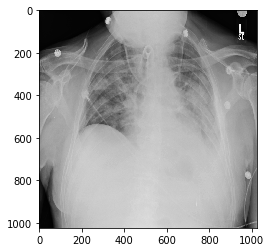

In [32]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00008875_021.png
And the real label of this image is :  Infiltration

This image has  0.98  of probability to have Infiltration
This image has  0.36  of probability to have Atelectasis
This image has  0.54  of probability to have Effusion


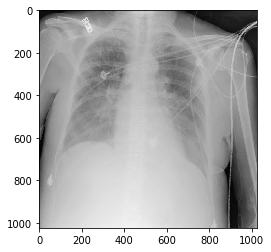

In [49]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00007153_001.png
And the real label of this image is :  Infiltration

This image has  0.17  of probability to have Infiltration
This image has  0.61  of probability to have Atelectasis
This image has  0.9  of probability to have Effusion


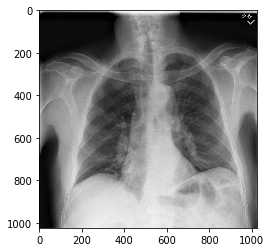

In [50]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00014125_057.png
And the real label of this image is :  Infiltration

This image has  0.55  of probability to have Infiltration
This image has  0.22  of probability to have Atelectasis
This image has  0.58  of probability to have Effusion


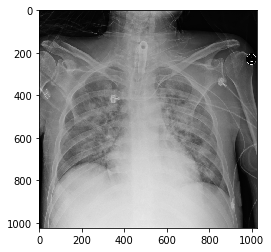

In [51]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00015647_027.png
And the real label of this image is :  Infiltration

This image has  0.97  of probability to have Infiltration
This image has  0.15  of probability to have Atelectasis
This image has  0.28  of probability to have Effusion


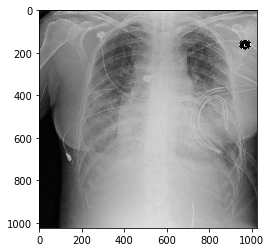

In [48]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00013781_002.png
And the real label of this image is :  Atelectasis

This image has  0.54  of probability to have Infiltration
This image has  0.88  of probability to have Atelectasis
This image has  0.59  of probability to have Effusion


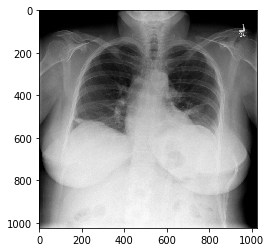

In [42]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00014977_000.png
And the real label of this image is :  No Finding

This image has  0.57  of probability to have Infiltration
This image has  0.2  of probability to have Atelectasis
This image has  0.23  of probability to have Effusion


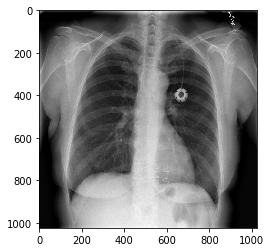

In [38]:
predict_random_image(os.getcwd()+"/images_2")

The chosen image is :  00004605_019.png
And the real label of this image is :  Effusion

This image has  0.65  of probability to have Infiltration
This image has  0.79  of probability to have Atelectasis
This image has  0.72  of probability to have Effusion


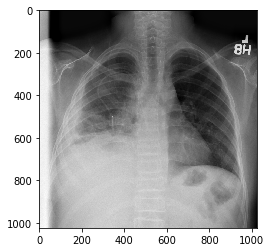

In [36]:
predict_random_image(os.getcwd()+"/images_2")

# 8. Conclusion
Although the accuracy is not very high, we were able to build models to predict among "no disease found", Infiltration, Atelectasis, and Effusion. Since the accuracy of our models is about 70%, the model predicts with the probability of either high(0.7~) or low(~0.3). However, we conclude that these models are not enough accurate to help doctors diagnose patients. In order to improve the accuracy, we still need to work on things such as listed below.

1. Use high resolution images
2. Train with more images
3. Increase the number of iterations
4. Use powerful computers
5. Build a prediction model for categorical classification to save time